In [166]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import jpype
import jpype.imports
from jpype import isJVMStarted, startJVM, getDefaultJVMPath, JPackage, JArray, JDouble, JInt


from thoi.commons import gaussian_copula_covmat
from thoi.heuristics import simulated_annealing, greedy

### First start the java virtual environment

This is necessary to run the jidt package to compute the Kraskov O-information.

For more info on installation and how to use, check [JIDT github repo](https://github.com/jlizier/jidt/tree/master)

In [16]:
jarLocation='/Users/ec627/Documents/toolkits/infodynamics-dist-1.6.1/infodynamics.jar'
if jpype.isJVMStarted() == False:
    jpype.startJVM(
        jpype.getDefaultJVMPath(),
        "-ea",
        f"-Djava.class.path={jarLocation}"
    )

## SBT and Gaussian copula functions

In [17]:
def network_energy(corrmat: np.ndarray, cuberootQ: bool = False) -> float:
    """
    Compute the network energy-balance U from a correlation matrix.

    ---
    Notes:
    code adapted from: https://github.com/majidsaberi/NetEnergyCogControl/blob/main/NetworkEnergy.R
    Originally written in R by Majid Saberi, March, 2024
    
    in this version, you can choose whther using the cuberoot, such as in Saberi et al (2024) or without, such as in Marvel and Strogatz (2009)
    Adapted to Python by Enrico Caprioglio, July, 2025
    """

    if corrmat.ndim != 2 or corrmat.shape[0] != corrmat.shape[1]:
        raise ValueError("corrmat must be a square 2-D array")

    n = corrmat.shape[0]
    if n < 3:
        raise ValueError("At least three nodes are required (matrix must be 3×3 or larger)")

    total_energy = 0.0
    triplet_count = 0

    # iterate over unordered triplets (i < j < k)
    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                prod = corrmat[i, j] * corrmat[i, k] * corrmat[k, j]
                
                if cuberootQ == False:
                    # Marvel and Strogatz (2009) – no cube root
                    triplet_energy = np.sign(prod) * abs(prod)
                else:
                    # cube-root variant (such as Saberi et al (2024))
                    triplet_energy = np.sign(prod) * np.cbrt(abs(prod))

                total_energy += triplet_energy
                triplet_count += 1

    return -total_energy / triplet_count

In [18]:
def cov2corr(covmat):
    std = np.sqrt(np.diag(covmat))
    denom = np.outer(std, std)
    corrmat = covmat / denom

    return corrmat

## Load dataset from Cliffs
Here, we study the relationship between the O-information and the structural balance-energy U using the datasets ([Zenodo link here](https://zenodo.org/records/7118947)) accompaying the paper Cliff et al (2023) "Unifying pairwise interactions in complex dynamics" Nat Comput Sci 3, 883–893

Make sure the packages above are installed and that the you have downloaded the MTS timeseries data (link above).

In [20]:
# load dataset
datasets = np.load('/Users/ec627/Documents/Sussex/papers/PRL Synergistic Motifs/data/database.pkl', allow_pickle=True)

In [141]:
# get dataset with real data
real_datasets = []
for dataset in datasets.keys():
    if 'real' in datasets[dataset]['labels']:
        real_datasets.append(dataset)
len(real_datasets)

548

In [140]:
# get dataset with real data (this is just to search more easily through the empirical datasets)
real_datasets_longTS = []
for dataset in datasets.keys():
    if 'real' in datasets[dataset]['labels']:
        nObs, nVars = np.shape(np.transpose(datasets[dataset]['data']))
        if nObs > 50:
            real_datasets_longTS.append(dataset)

len(real_datasets_longTS)

410

Below we select the first example of each of these categories. For the Kraskov vs Gaussian estimators comparison, we simple select datasets with enough no. of observations and no. of variables between $5$ and $20$.

Medical data:
- `UEA Heartbeat`
- `UEA HandMovementDirection`
- `UEA ArticularyWordRecognition`

Physiological data:
- `UEA Cricket`
- `UCLA res-state fMRI schizophrenia`
- `mouse fMRI`

Others:
- `UEA PEMS-SF`
- `epidemic incidence`
- `Dow–Jones Industrial Average index`

In [ ]:
# these are the selected time series from the dataset

indeces = [
    # from the real_dataset
    ## medicine
    149, # EEG example (SelfRegulation1 mouse-cursor)
    350, # MEG example (hand movement)
    446, # electromagnetic articulographs example
    491, # fMRI mouse example
    509, # fMRI human example (schizophrenia)
    15, # physiological data example (badminton basic motion)
    168, # physiological data example2 cricket

    ## finance
    # forex: 460-468
    # snp500: 469-474
    # DJIA: 475-482
    469, 475,

    ## others
    0, # eigenworms
    92, # san francisco car lanes
    270, # astronomy
    538, # epidemic incidence data example

    ## geophysical data
    # 992, # TestCLIM_S5
    # 995, # TestWEATH_S7
]

In [ ]:
def collect_Ogauss_Okraskov_U(dataset, order, cuberootQ=False):
    
    nObs,nVars=np.shape(dataset)

    num_comb=math.comb(nVars, order) # get number of N-plets
    nplets,nplets_O_info=greedy(dataset, order, order, repeat=num_comb)

    # get correlation matrix
    covmat=gaussian_copula_covmat(dataset)
    corrmat=cov2corr(covmat)

    U_data = []
    O_data = []
    O_kraskov_data = []

    for (idx, nplet) in enumerate(nplets):

        if order < nVars:

            # --- compute O-info and structural balance-energy U using Gaussian Copula ------
            U = network_energy(corrmat[np.ix_(nplet, nplet)], cuberootQ=cuberootQ)
            O = nplets_O_info[idx]

            # --- compute O-info using kraskov ------
            # get subset of interest
            data_subset = dataset[:, nplet]

            oinfo_class = JPackage("infodynamics.measures.continuous.kraskov").OInfoCalculatorKraskov
            oinfo_estimator = oinfo_class()

            # NOTE: in an N-plet of order N, order is the same as no. of variables
            oinfo_estimator.initialise(order) 

            arr = JArray(JDouble, 2)(data_subset.tolist())
            oinfo_estimator.setObservations(arr)

            O_kraskov = oinfo_estimator.computeAverageLocalOfObservations()

            U_data.append(U)
            O_data.append(O)
            O_kraskov_data.append(O_kraskov)

    return nplets, U_data, O_data, O_kraskov_data

In [136]:
for idx in indeces:
    dataset_name = real_datasets[idx]
    order = 7

    data=np.transpose(datasets[dataset_name]['data'])
    nObs, nVars = np.shape(data)

    if  order < nVars:
        nplets, U_data, O_data, O_kraskov_data = collect_Ogauss_Okraskov_U(data, order, cuberootQ=False)

        filename = dataset_name + '_order_' + str(order) + '.npz'

        print('file saved as: ' + filename)
        folderpath = '/Users/ec627/Documents/Data/synergistic_motifs/kraskov_Oinfo/'

        np.savez(folderpath+filename, nplets=nplets, U_data=U_data, O_data=O_data, O_kraskov_data=O_kraskov_data, order=order)

file saved as: HandMovementDirection_C-backward_I-0_order_7.npz


file saved as: ArticularyWordRecognition_C-10_I-1_order_7.npz


file saved as: mousefMRI_S-0_R-23-24_order_7.npz


file saved as: UCLA_neuro_SCHZ_S-121_R-20-34_order_7.npz


file saved as: SNP500_N-481_P-12_2010-01-01-lr_order_7.npz


file saved as: DJIA_N-679_P-9_2010-01-01-lr_order_7.npz


file saved as: PEMS-SF_C-10_I-0_order_7.npz


file saved as: epidemic_incidence_C31-39_order_7.npz


The above is all you need! To reproduce the figures shown in the SM, please refer to the Julia notebook `Empirical_data_plots.jl`.

If you want to see a quick example, run the cells below.

In [286]:
for dataset_name in ['ForEx_N-886_P-9_2010-01-01-lr']:
    order = 6
    
    data=np.transpose(datasets[dataset_name]['data'])
    nObs, nVars = np.shape(data)

    if  order < nVars:
        nplets, U_data, O_data, O_kraskov_data = collect_Ogauss_Okraskov_U(data, order, cuberootQ=False)

        filename = dataset_name + '_order_' + str(order) + '.npz'

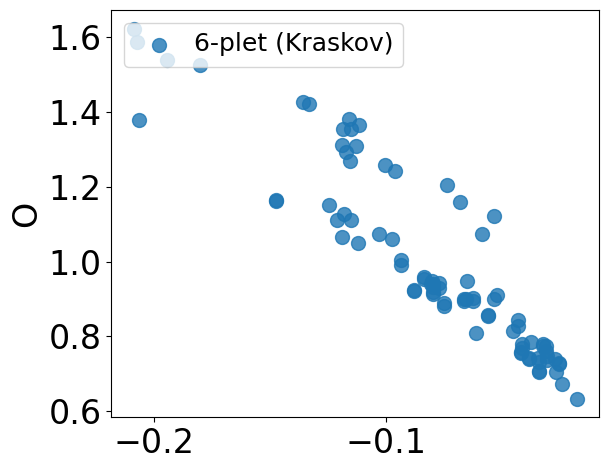

In [287]:
# plt.scatter(U_data, O_data, marker="o", s=100, label=f"{order}-plet (Gauss. copula)",alpha=0.8)
plt.scatter(U_data, O_kraskov_data, marker="o", s=100, label=f"{order}-plet (Kraskov)", alpha=0.8)

# plt.xlabel("U", fontsize =24)
plt.ylabel("O", fontsize =24)
plt.tick_params(axis='both', labelsize=24)
plt.tight_layout()
plt.legend(
    fontsize=18,
    loc="upper left",
    frameon=True,
    handletextpad=0.4
)
plt.show()

### Examples for continuous and discrete data

### Kraskov estimator O-info

This is just a quick small demo for the JIDT Kraskov estimator O-info using randomly generated continuous data.

In [52]:
nObs=10_000
nVars=10

data = np.random.randn(nObs,nVars)

print("shape:", data.shape)
print("min, max:", data.min(), data.max())

oinfo_class = JPackage("infodynamics.measures.continuous.kraskov").OInfoCalculatorKraskov
oinfo_estimator = oinfo_class()

oinfo_estimator.initialise(nVars)

arr = JArray(JDouble, 2)(data.tolist()) # for continuous use JDouble
oinfo_estimator.setObservations(arr)

O = oinfo_estimator.computeAverageLocalOfObservations()
print(O)

shape: (10000, 10)
min, max: -4.078206898960358 4.752924116703897
-0.008860568866419097


### Dicrete O-info estimator

Using first XOR process

In [105]:
filename = '/Users/ec627/Documents/Data/to_python/example_xor_10000.npy'

data=np.load(filename)
nObs, nVars = np.shape(data) # np.shape(np.transpose(data))
data_discrete = data.astype(np.int32)
base=2

print("shape:", data_discrete.shape)
print("base:", base)
print("min, max:", data_discrete.min(), data_discrete.max())

oinfo_class = JPackage("infodynamics.measures.discrete").OInfoCalculatorDiscrete
oinfo_estimator = oinfo_class(base, nVars)

oinfo_estimator.initialise()
arr = JArray(JInt, 2)(data.tolist()) # for continuous use JDouble
oinfo_estimator.addObservations(arr)

oinfo_estimator.computeAverageLocalOfObservations()

shape: (10000, 8)
base: 2
min, max: 0 1


-5.982542210927672